In [95]:
# imports 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
plt.style.use('fivethirtyeight')
import math
import seaborn as sns
from datetime import datetime

import requests
from termcolor import colored as cl 
plt.rcParams['figure.figsize'] = (20, 10)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 100)


In [96]:
# data import 
df = pd.read_excel('Time Series Data.xlsx', index_col = 'Day')
df.head()
df.tail()

,Series 1,Series 2,Series 3,Series 4,Series 5,Series 6,Series 7,Series 8,Series 9,Series 10,Series 11,Series 12,Series 13,Series 14,Series 15,Series 16,Series 17,Series 18,Series 19,Series 20,Series 21,Series 22,Series 23,Series 24,Series 25,Series 26,Series 27,Series 28,Series 29
Day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2602,1068.632552,1336.228529,250.467832,628.636139,520.120714,135.336090,152.596035,975.221144,387.600334,178.429607,261.032386,646.040388,4361.256545,1401.269550,299.974121,280.657767,282.444886,139.897582,75.009201,36.052849,133.667844,76.928467,80.455647,118.244704,387.835836,284.502070,269.421370,63.223553,49.350649
2603,1089.834425,1395.646004,254.419892,634.847737,521.588464,135.049484,153.458825,975.884108,390.275202,177.730774,262.511430,651.335590,4353.795812,1404.616544,300.661241,280.657767,282.468599,140.117251,75.696234,37.869529,134.769500,76.980504,80.721701,118.487895,390.846986,285.961041,270.422318,63.123752,49.350649
2604,1089.421252,1396.415235,253.909722,636.683560,521.767458,133.762744,153.093788,972.127936,391.971857,179.025088,264.086046,652.526337,4307.460733,1390.993028,300.203459,282.607779,282.634095,139.637759,75.745307,36.862097,134.771284,77.517519,81.310996,118.278210,390.163835,285.970750,270.647848,67.015968,48.831169
2605,1095.886638,1379.305452,253.399904,637.812262,514.679296,132.190891,152.522957,960.372251,388.970682,178.041398,263.704274,646.902290,4231.806283,1364.273601,297.073049,278.976813,282.185034,138.818605,75.622623,36.135425,135.130771,77.689586,81.498104,117.675097,387.537363,284.317602,268.917683,73.952096,49.350649
2606,1103.894534,1380.014937,254.611030,634.847737,517.757993,132.905913,152.609264,965.100894,390.471269,179.025088,264.086046,647.353662,4235.209424,1381.771717,299.134408,279.940678,280.861564,139.418089,74.960128,36.168456,135.318097,77.772150,82.410021,117.383268,388.690100,285.155209,269.638585,68.762475,49.870130


In [97]:
def sma_bb(data, window):
    sma = data.rolling(window = window).mean()
    std = data.rolling(window = window).std()
    upper_bb = sma + std * .25
    lower_bb = sma - std * .2
    return lower_bb, upper_bb, sma


In [98]:
def implement_bb_strategy(data, lower_bb, upper_bb):
    buy_price = []
    sell_price = []
    bb_signal = []
    signal = 0

    for i in range(len(data)):
        if i == 0:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(signal)
        elif data[i-1] > lower_bb[i-1] and data[i] < lower_bb[i]:
            if signal != 1:
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        elif data[i-1] < upper_bb[i-1] and data[i] > upper_bb[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)

        position = []

    for i in range(len(bb_signal)):    
        if bb_signal[i] > 1:
            position.append(0)
        else:
            position.append(1)

    sigPriceBuy = []
    sigPriceSell = []

    for i in range(len(data)):
        if i == 0: 
            position[i] = 0
            sigPriceBuy.append(np.nan)
            sigPriceSell.append(np.nan)
        elif bb_signal[i] == 1:
            position[i] = 1
            sigPriceBuy.append(data[i])
            sigPriceSell.append(np.nan)
        elif bb_signal[i] == -1:
            position[i] = 0
            sigPriceBuy.append(np.nan)
            sigPriceSell.append(data[i])
        else:
            position[i] = position[i-1]
            sigPriceBuy.append(np.nan)
            sigPriceSell.append(np.nan)

    return position, buy_price, sell_price
            
       

In [99]:
def PnL(data, position):
    gain = 0
    real_profit = 0
    series_ret = pd.DataFrame(np.diff(data)).rename(columns = {0:'returns'})
    for i in range(len(series_ret)):
        try:
            returns = series_ret['returns'][i]*position[i]
            gain += returns 
        except:
            pass
    real_profit = gain - (data.iloc[-1] - data[0])
    return real_profit


In [100]:
# Testing series 28

bb_temp = sma_bb(df['Series 28'], int(200))
position_temp = implement_bb_strategy(df['Series 28'], bb_temp[0], bb_temp[1])
position_df = pd.Series(position_temp)
profit_temp = PnL(df['Series 28'], position_df)
profit.append(profit_temp)

print(profit_temp)


31.237524950099882


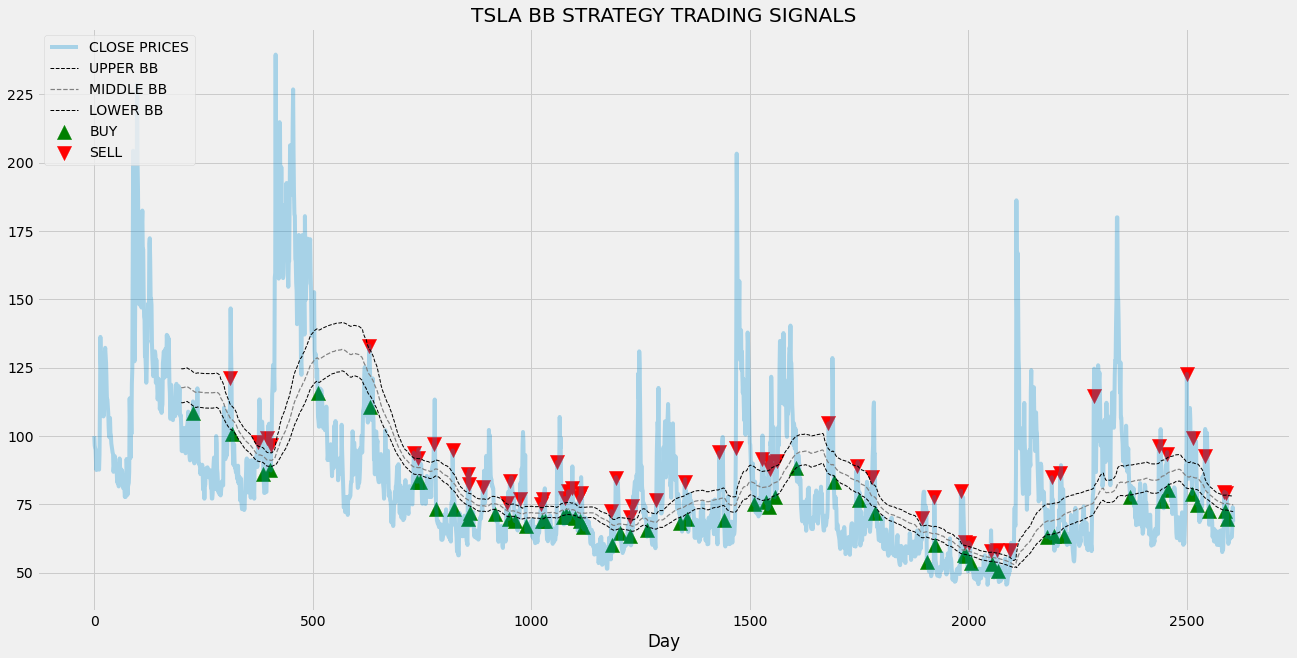

In [101]:
df['Series 28'].plot(label = 'CLOSE PRICES', alpha = 0.3)
bb_temp[1].plot(label = 'UPPER BB', linestyle = '--', linewidth = 1, color = 'black')
bb_temp[2].plot(label = 'MIDDLE BB', linestyle = '--', linewidth = 1.2, color = 'grey')
bb_temp[0].plot(label = 'LOWER BB', linestyle = '--', linewidth = 1, color = 'black')
plt.scatter(df.index, position_temp[1], marker = '^', color = 'green', label = 'BUY', s = 200)
plt.scatter(df.index, position_temp[2], marker = 'v', color = 'red', label = 'SELL', s = 200)
plt.title('TSLA BB STRATEGY TRADING SIGNALS')
plt.legend(loc = 'upper left')
plt.show()

In [62]:
# Testing all date

# variables
# lag = 0
upper_window = 200
lower_window = 10

profit_df = pd.DataFrame(columns = df.columns)
max_profit = pd.DataFrame(columns = df.columns)

# iterating over different windows and series to find matrix of returns
for i in np.linspace(lower_window,upper_window,int(upper_window/10)):

    profit = []

    for column in df:

        bb_temp = sma_bb(df[column], int(i))
        position_temp = implement_bb_strategy(df[column], bb_temp[0], bb_temp[1])
        position_df = pd.Series(position_temp)
        profit_temp = PnL(df[column], position_df)
        profit.append(profit_temp)

    profits = pd.DataFrame(columns = df.columns).transpose()
    profits[i] = profit
    profits = profits.transpose()
    profit_df = pd.concat([profit_df, profits])

profit_df.to_excel(r'/Users/halelee/Python/BH Algo/PythonResult.xlsx', sheet_name='Sheet1', index = False)

profit_df

,Series 1,Series 2,Series 3,Series 4,Series 5,Series 6,Series 7,Series 8,Series 9,Series 10,Series 11,Series 12,Series 13,Series 14,Series 15,Series 16,Series 17,Series 18,Series 19,Series 20,Series 21,Series 22,Series 23,Series 24,Series 25,Series 26,Series 27,Series 28,Series 29
10.0,-661.867234,-571.306945,19.388218,-311.085198,-212.718954,-21.770089,-45.647656,-537.050232,-27.127366,-33.044512,1.159265,-80.859207,-3576.753927,-364.883644,-74.236583,-63.94478,-129.541923,-8.198382,8.894614,56.036334,-26.200671,7.85749,13.362964,-20.372892,-20.655687,-27.729283,-59.64072,239.720559,36.363636
20.0,-682.824264,-728.820015,-8.187315,-232.342169,-271.504516,-1.309131,14.082811,-478.725314,-61.326604,-60.330445,4.746062,-178.539188,-4006.899215,-557.808084,-36.287055,-50.306674,-71.897393,-13.239435,-7.765918,64.013212,-30.626918,6.777215,5.862498,-18.04907,-22.635829,-14.893335,-13.542285,276.696607,4.675325
30.0,-640.198629,-972.180732,-44.611768,-205.284717,-166.75867,-121.346151,-4.083098,-446.380816,-246.771613,-25.223411,-1.329745,-286.199463,-3921.933246,-1107.308743,-88.068212,-43.199515,-97.770752,28.799803,11.704085,62.460776,-13.162777,7.697912,13.351775,-20.840899,-142.224552,-27.326808,-28.511068,174.500998,37.402597
40.0,-814.470221,-820.746826,-32.37085,-189.421596,-240.359563,-72.50974,-22.463691,-520.436864,-170.520534,-18.522766,14.509921,-400.674111,-3291.399215,-1154.748445,-80.623226,-42.996823,-57.812496,38.999301,-33.149307,91.379026,-26.213159,4.810241,27.032386,-19.954604,-132.137133,-33.173285,-33.090356,154.141717,7.012987
50.0,-767.351717,-750.485437,-104.895102,-98.128298,-203.250173,-30.562314,-21.367879,-643.176335,-137.36746,-16.189263,-34.785686,-384.934189,-3679.637435,-1160.870077,-75.497492,-85.107408,-115.512357,53.741697,23.88664,119.108175,-28.212196,9.632276,19.996892,-24.693039,-93.799655,-57.459466,-60.322129,74.850299,4.155844
60.0,-995.263818,-781.000747,-91.668277,-110.859458,-125.801625,-36.519831,-12.277084,-659.078583,-142.261357,-38.272738,-38.159642,-398.350723,-4351.681937,-1093.906633,-111.011761,-90.579613,-112.419568,78.120483,2.343271,111.36251,-30.820488,-1.561785,15.584634,-31.813662,-82.249331,-62.914059,-58.177185,38.373253,-3.636364
70.0,-945.16129,-894.660194,-64.529129,-178.908971,-128.600016,-46.934663,-35.17014,-613.238704,-119.277595,-9.066429,-25.947069,-398.494724,-3736.704188,-1289.39137,-82.222341,-119.301503,-95.304376,69.887614,21.0649,100.825764,-25.010704,3.17283,23.65326,-32.948552,-146.044914,-67.240664,-51.743393,101.147705,-5.974026
80.0,-983.488401,-743.920836,-66.403618,-144.958216,-118.065863,22.783658,-43.063206,-624.920519,-132.984612,6.121588,-30.04169,-387.262209,-3135.451571,-1217.333239,-58.576502,-105.120729,-78.189925,61.485625,38.645565,88.35673,-23.300685,5.616457,17.764033,-30.900346,-137.238457,-56.744543,-64.387904,119.91018,4.155844
90.0,-998.478913,-932.23301,-78.762592,-131.596179,-71.494492,69.618307,-38.012951,-652.197879,-101.468735,-14.9462,-44.124378,-394.87322,-2905.835079,-1464.690503,-42.946762,-112.268378,-85.972656,27.560208,43.957797,94.995871,-39.775566,8.653299,15.753093,-30.19131,-165.847636,-95.269155,-79.394291,108.632735,-1.038961
100.0,-905.52274,-831.516057,-69.793859,-121.78021,-166.715711,82.917108,-36.58542,-553.932899,-104.198106,-17.11802,-76.51921,-406.302369,-2646.801047,-1454.15489,-43.925684,-103.232051,-104.654374,35.015967,27.886149,104.227911,-29.700992,10.093665,10.869025,-28.192823,-175.174795,-103.81292,-82.709496,106.636727,15.584416
